## **Import Library**

In [ ]:
!pip install opendatasets

In [ ]:
!pip install split-folders

In [7]:
import matplotlib.pyplot as plt
import opendatasets as od
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## **Download Gambar Dataset**

In [119]:
od.download("https://www.kaggle.com/kaustubhdikshit/neu-surface-defect-database")

Skipping, found downloaded files in "./neu-surface-defect-database" (use force=True to force download)


## **Preprocessing Gambar**

In [10]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=45,
    width_shift_range=.15,
    height_shift_range=.15,
    horizontal_flip=True,
    zoom_range=0.5
)

training_set = train_datagen.flow_from_directory(
    'neu-surface-defect-database/NEU-DET/train/images',
    target_size = (224, 224),
    batch_size = 32,
)

Found 1440 images belonging to 6 classes.


In [11]:
test_datagen = ImageDataGenerator(rescale = 1./255)

test_set = test_datagen.flow_from_directory(
    'neu-surface-defect-database/NEU-DET/validation/images',
    target_size = (224, 224),
    batch_size = 32,
)

Found 360 images belonging to 6 classes.


In [12]:
from keras.applications.mobilenet import MobileNet
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D

MobileNet_model = MobileNet(include_top=False, input_shape= (224, 224, 3))

x = MobileNet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation="relu")(x)


cnn = Model(inputs = MobileNet_model.input, outputs = Dense(6, activation='softmax')(x))
cnn.compile(
    optimizer='adam',
    loss="categorical_crossentropy",
    metrics=['accuracy']
)

In [13]:
cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128       
 ation)                                                      

## **Training Model**

In [14]:
history = cnn.fit(
    training_set,
    epochs = 10,
    validation_data=test_set,
    verbose = 2
)

Epoch 1/10
45/45 - 14s - loss: 0.4223 - accuracy: 0.8750 - val_loss: 12.4607 - val_accuracy: 0.4250 - 14s/epoch - 318ms/step
Epoch 2/10
45/45 - 12s - loss: 0.2090 - accuracy: 0.9424 - val_loss: 8.2127 - val_accuracy: 0.4861 - 12s/epoch - 266ms/step
Epoch 3/10
45/45 - 12s - loss: 0.1321 - accuracy: 0.9646 - val_loss: 3.6435 - val_accuracy: 0.7333 - 12s/epoch - 270ms/step
Epoch 4/10
45/45 - 12s - loss: 0.0987 - accuracy: 0.9681 - val_loss: 0.4924 - val_accuracy: 0.8472 - 12s/epoch - 266ms/step
Epoch 5/10
45/45 - 12s - loss: 0.0650 - accuracy: 0.9819 - val_loss: 3.1852 - val_accuracy: 0.7556 - 12s/epoch - 267ms/step
Epoch 6/10
45/45 - 12s - loss: 0.0707 - accuracy: 0.9833 - val_loss: 0.8892 - val_accuracy: 0.8917 - 12s/epoch - 267ms/step
Epoch 7/10
45/45 - 12s - loss: 0.1338 - accuracy: 0.9604 - val_loss: 0.3988 - val_accuracy: 0.9028 - 12s/epoch - 268ms/step
Epoch 8/10
45/45 - 12s - loss: 0.1079 - accuracy: 0.9694 - val_loss: 0.2634 - val_accuracy: 0.8944 - 12s/epoch - 271ms/step
Epoch 9

## **Evaluasi Model**

In [15]:
history = history.history

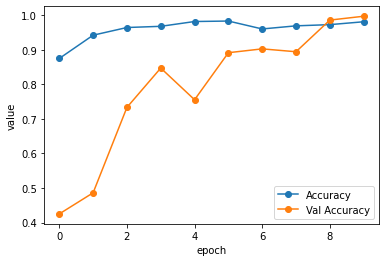

In [16]:
plt.plot(history['accuracy'], label="Accuracy", marker = "o")
plt.plot(history['val_accuracy'], label="Val Accuracy", marker = "o")
plt.xlabel("epoch")
plt.ylabel("value")
plt.legend()
plt.show()

## **Evaluation Model**

In [17]:
path = "neu-surface-defect-database/NEU-DET/validation/images"
main_dir = os.listdir(path)
main_dir.sort()

In [18]:
actual = []
result = []

In [19]:
for idx, i in enumerate(main_dir):
    folder_classification = os.listdir(os.path.join(path, i))
    for j in folder_classification:
        img = image.load_img(f"{path}/{i}/{j}")
        predict = image.img_to_array(img) / 255
        predict = tf.image.resize(predict, (224,224))
        predict = tf.expand_dims(predict, axis=0)
        prediction = cnn.predict(x=predict)
        
        actual.append(idx)
        result.append(np.argmax(prediction))

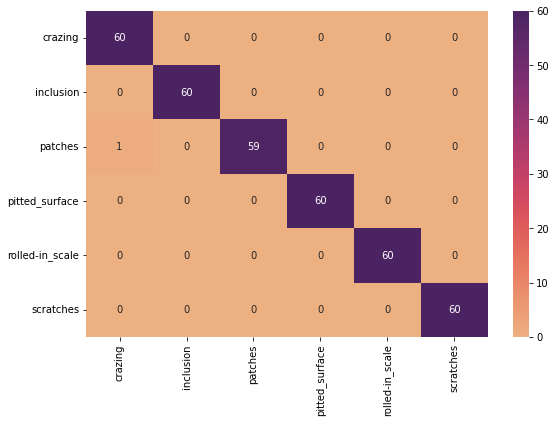


               precision    recall  f1-score   support

           0       0.98      1.00      0.99        60
           1       1.00      1.00      1.00        60
           2       1.00      0.98      0.99        60
           3       1.00      1.00      1.00        60
           4       1.00      1.00      1.00        60
           5       1.00      1.00      1.00        60

    accuracy                           1.00       360
   macro avg       1.00      1.00      1.00       360
weighted avg       1.00      1.00      1.00       360



In [28]:
conf_matrix = confusion_matrix(actual, result)

plt.figure(figsize=(9, 6))

sns.heatmap(
    conf_matrix, 
    annot=True, 
    xticklabels=main_dir, 
    yticklabels=main_dir, 
    cmap='flare', fmt='d'
)

plt.show()

print("\n", classification_report(actual, result))

## **Contoh Prediksi Gambar**

In [21]:
def predict_image(img):    
    predict = image.img_to_array(img) / 255
    predict = tf.image.resize(predict, (224,224))
    predict = tf.expand_dims(predict, axis=0)
    prediction = cnn.predict(x=predict)
    
    return np.argmax(prediction)

Hasil Prediksi Gambar : pitted_surface (3) 



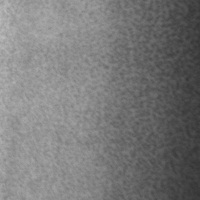

In [25]:
img = image.load_img("neu-surface-defect-database/NEU-DET/validation/images/pitted_surface/pitted_surface_257.jpg")
prediction = predict_image(img)
print(f"Hasil Prediksi Gambar : {main_dir[prediction]} ({prediction}) \n")
img

Hasil Prediksi Gambar : rolled-in_scale (4) 



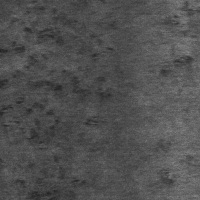

In [26]:
img = image.load_img("neu-surface-defect-database/NEU-DET/validation/images/rolled-in_scale/rolled-in_scale_255.jpg")
prediction = predict_image(img)
print(f"Hasil Prediksi Gambar : {main_dir[prediction]} ({prediction}) \n")
img